# Open-loop planning with straightline plans in JaxPlan.

This rudimentary example illustrates how to set up an offline JaxPlan agent that first optimizes the problem and then evaluates.

First install and import the required packages:

In [1]:
%pip install --quiet --upgrade pip
%pip install --quiet pyRDDLGym rddlrepository pyRDDLGym-jax

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import the required packages:

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import os
from IPython.display import Image

import pyRDDLGym
from pyRDDLGym.core.visualizer.movie import MovieGenerator
from pyRDDLGym_jax.core.planner import JaxStraightLinePlan, JaxBackpropPlanner, JaxOfflineController, load_config_from_string

We will optimize the reacher multi-jointed arm control problem. Please note that the environment state and action fluents should be vectorized tensors for JaxPlan, so we **must enable the ``vectorized`` option**:

In [3]:
env = pyRDDLGym.make('Reacher_gym', '0', vectorized=True)

Now we will construct a straight-line offline planner as our policy, using the default parameters. This instantiates an independent trainable parameter vector for each action-fluent per decision time step. Note that the controller is an instance of the pyRDDLGym ``BasePolicy``, so it will support normal interaction with pyRDDLGym environments out of the box:

In [4]:
planner = JaxBackpropPlanner(rddl=env.model, plan=JaxStraightLinePlan())
agent = JaxOfflineController(planner, print_summary=False, train_seconds=30)
agent.evaluate(env, episodes=1)

[INFO] JAX gradient compiler will cast p-vars {'POS', 'TARGET-SEGMENT'} to float.
[INFO] Bounds of action-fluent <torque> set to (array([-1., -1.], dtype=float32), array([1., 1.], dtype=float32)).
[WARN] policy_hyperparams is not set, setting 1.0 for all action-fluents which could be suboptimal.


      0 it /     -171.72444 train /     -191.15672 test /     -191.15672 best / 0 status /      1 pgpe:   6%| | 00:01 ,

[WARN] policy_hyperparams is not set, setting 1.0 for all action-fluents which could be suboptimal.


   4584 it /     -182.50018 train /     -193.11696 test /     -135.55899 best / 5 status /     42 pgpe: 100%|█| 00:29 ,

{'mean': np.float64(-132.6466630502829),
 'median': np.float64(-132.6466630502829),
 'min': np.float64(-132.6466630502829),
 'max': np.float64(-132.6466630502829),
 'std': np.float64(0.0)}

We can do better! Since JaxPlan can be sensitive to hyper-parameter choices, Let's repeat the previous exercise but with tweaked hyper-parameters. Specifically, let's decrease the learning rate, change the optimizer to ADAM, and remove mini-batching since this environment is deterministic. This is much easier to provide in a configuration file as follows:

In [5]:
config = """
[Model]
[Optimizer]
method='JaxStraightLinePlan'
optimizer='adam'
optimizer_kwargs={'learning_rate': 0.0001}
batch_size_train=1
batch_size_test=1
pgpe=None
[Training]
key=42
"""
planner_args, _, train_args = load_config_from_string(config)

In [6]:
planner = JaxBackpropPlanner(rddl=env.model, **planner_args)
agent = JaxOfflineController(planner, print_summary=False, train_seconds=30, **train_args)
agent.evaluate(env, episodes=1)

[INFO] JAX gradient compiler will cast p-vars {'POS', 'TARGET-SEGMENT'} to float.
[INFO] Bounds of action-fluent <torque> set to (array([-1., -1.], dtype=float32), array([1., 1.], dtype=float32)).
[WARN] policy_hyperparams is not set, setting 1.0 for all action-fluents which could be suboptimal.


      0 it /     -184.75497 train /     -164.18906 test /     -164.18906 best / 0 status /      0 pgpe:   4%| | 00:00 ,

[WARN] policy_hyperparams is not set, setting 1.0 for all action-fluents which could be suboptimal.


  17583 it /       -6.43684 train /       -6.43714 test /       -6.43714 best / 5 status /      0 pgpe: 100%|█| 00:30 ,


{'mean': np.float64(-6.436748762783277),
 'median': np.float64(-6.436748762783277),
 'min': np.float64(-6.436748762783277),
 'max': np.float64(-6.436748762783277),
 'std': np.float64(0.0)}

Let's visualize our trained agent's behavior:

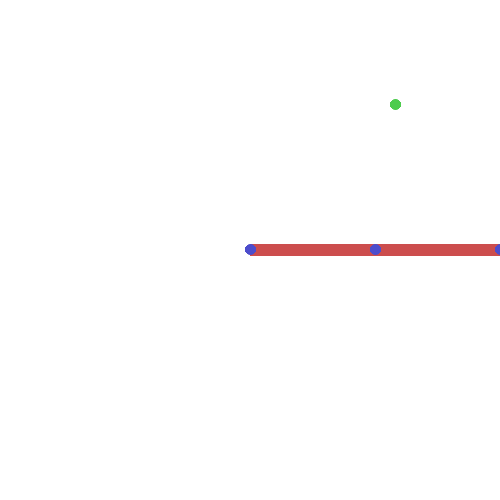

In [7]:
if not os.path.exists('frames'):
    os.makedirs('frames')
recorder = MovieGenerator("frames", "reacher", max_frames=env.horizon)
env.set_visualizer(viz=None, movie_gen=recorder)
agent.evaluate(env, episodes=1, render=True)
env.close()
Image(filename='frames/reacher_0.gif') 